In [1]:
#Import required packages
from IPython.display import Image
import csv
import math
import os
from itertools import tee
import pprint
import numpy as np
from shapely.geometry import LineString, Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import contextily as ctx

The aim of this notebook is to explore new infrastructure modelling methods for network planning. 

Currenetly, it is common to find 2D snapshots being used for the busiest hour of the day. 

While this is satisfactory, 2D snapshots ignore most spatial and temporal heterogeneity. 

Hence, the aim here is to try integrate:
    
    (i) height/elevation factors, to achieve three dimensional modelling 
    (ii) temporal factors, to achieve four dimensional modelling
   
The exploratory approach will utilise one cell site, and a single 3 kilometre stretch of road. 

Different hourly vehicle densities will then be used to capture spatio-temporal variability.

As certain physical factors are time invariant (cell site height, the physical road envrionment etc.),
these only need to be captured once. 

The image below shows conceptually how this modelling approach works.

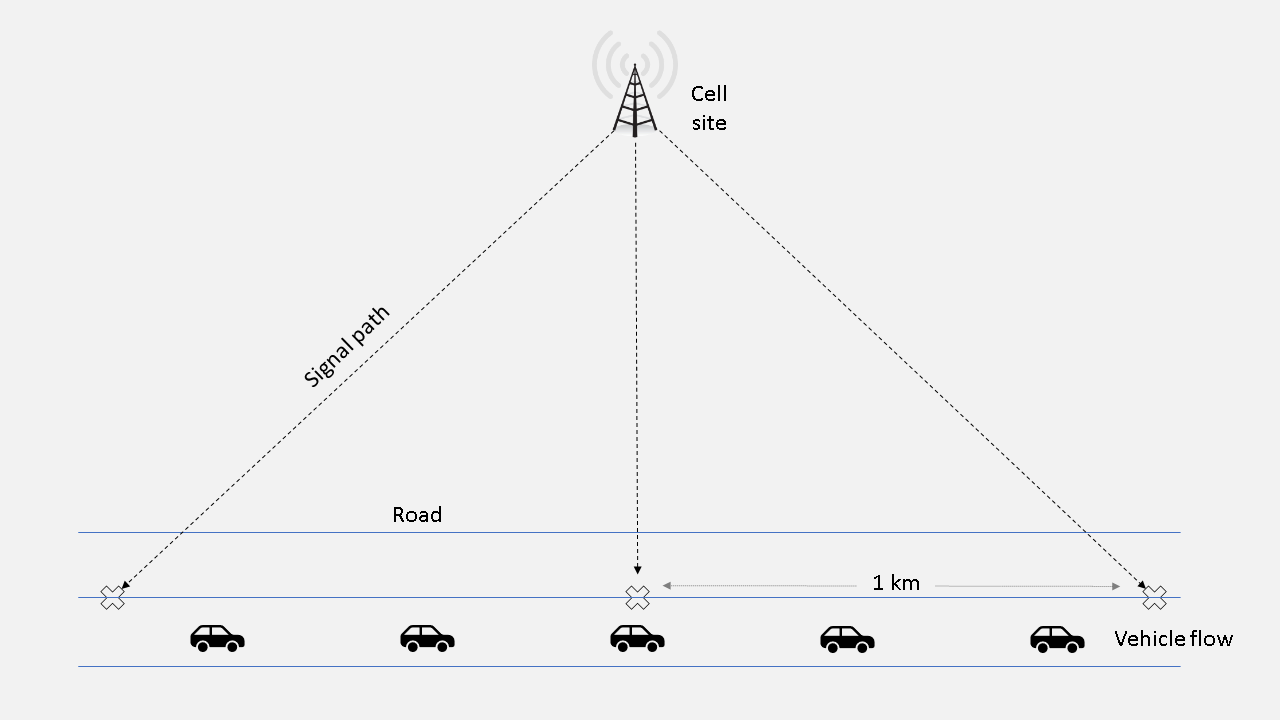

In [2]:
Image(filename = 'graphic/graphic.png', width=700, height=700)

In [3]:
#We can then specify the single cell site location as a geojson object
site ={
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [3, 3]
  },
  "properties": {
    "height": 30
    }
}
pprint.pprint(site)

{'geometry': {'coordinates': [3, 3], 'type': 'Point'},
 'properties': {'height': 30},
 'type': 'Feature'}


In [4]:
#As well as the road and its physical lat, long and height coordinates
road_points = [
    {
      "type": "Feature",
      "geometry": {"type": "Point", "coordinates": (1, 1)},
      "properties": {"height": 1}
    },
    {
      "type": "Feature",
      "geometry": {"type": "Point", "coordinates": (1, 3)},
      "properties": {"height": 15}
    },
    {
      "type": "Feature",
      "geometry": {"type": "Point", "coordinates": (1, 5)},
      "properties": {"height": 29}
    },
]
pprint.pprint(road_points)

[{'geometry': {'coordinates': (1, 1), 'type': 'Point'},
  'properties': {'height': 1},
  'type': 'Feature'},
 {'geometry': {'coordinates': (1, 3), 'type': 'Point'},
  'properties': {'height': 15},
  'type': 'Feature'},
 {'geometry': {'coordinates': (1, 5), 'type': 'Point'},
  'properties': {'height': 29},
  'type': 'Feature'}]


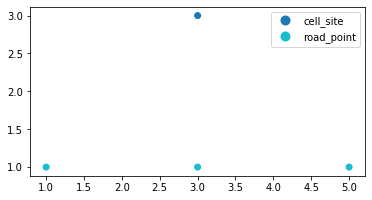

In [5]:
#Let's first plot the data to explore it visually for each point type.
#For simplicity, height is  
df = pd.DataFrame(
    {'type': ['cell_site', 'road_point', 'road_point', 'road_point'],
     'Latitude': [site['geometry']['coordinates'][0],
                  road_points[0]['geometry']['coordinates'][0],
                  road_points[1]['geometry']['coordinates'][0],
                  road_points[2]['geometry']['coordinates'][0]],
     'Longitude': [site['geometry']['coordinates'][1],
                  road_points[0]['geometry']['coordinates'][1],
                  road_points[1]['geometry']['coordinates'][1],
                  road_points[2]['geometry']['coordinates'][1]],
     'height': [site['properties']['height'],
                  road_points[0]['properties']['height'],
                  road_points[1]['properties']['height'],
                  road_points[2]['properties']['height']],
    })

#create matplotlib subplot
fig, ax = plt.subplots(1, 1)

#convert to geopandas dataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

#plot based on the point type, with the point size based on the height
gdf.plot(column='type', ax=ax, legend=True)

In [6]:
def extended_hata(frequency, distance, ant_height, ue_height, 
                  settlement_type, seed_value, iterations):
    """
    Implements the Extended Hata path loss model.
    
    Parameters
    ----------
    frequency : int
        Carrier band (f) required in MHz.
    distance : int
        Distance (d) between transmitter and receiver 
        required in kilometres.
    ant_height : int
        Transmitter antenna height (h1) (m, above ground).
    ue_height : int
        Receiver antenna height (h2) (m, above ground).
    settlement_type : string
        General environment (urban/suburban/rural)
    seed_value : int
        Set the seed for the pseudo random number generator 
        allowing reproducible stochastic restsults.
    iterations : string
        Specify the number of random numbers to be generated. 
        The mean value will be used. 
        
    """
    #find smallest height value
    hm = min(ant_height, ue_height)
    
    #find largest height value
    hb = max(ant_height, ue_height)

    alpha_hm = (1.1*np.log10(frequency) - 0.7) * min(10, hm) - \
        (1.56*np.log10(frequency) - 0.8) + max(0, (20*np.log10(hm/10)))

    beta_hb = min(0, (20*np.log10(hb/30)))

    if distance <= 20: #units : km
        alpha_exponent = 1

    elif 20 < distance < 100: #units : km
        alpha_exponent = 1 + (0.14 + 1.87e-4 * frequency + \
            1.07e-3 * hb)*(np.log10(distance/20))**0.8
    else:
        raise ValueError('Distance over 100km not compliant')

    ###PART 1####
    #Determine initial path loss according to distance, frequency and environment.
    if distance < 0.04:
        path_loss = (32.4 + (20*np.log10(frequency)) + (10*np.log10((distance**2) +
            ((hb - hm)**2) / (10**6))))

    elif distance >= 0.1:

        if 30 < frequency <= 150:
            path_loss = (69.6 + 26.2*np.log10(150) - 20*np.log10(150/frequency) -
                13.82*np.log10(max(30, hb)) +
                (44.9 - 6.55*np.log10(max(30, hb))) *
                np.log10(distance)**alpha_exponent - alpha_hm - beta_hb)

        elif 150 < frequency <= 1500:
            path_loss = (69.6 + 26.2*np.log10(frequency) -
                13.82*np.log10(max(30, hb)) +
                (44.9 - 6.55*np.log10(max(30, hb))) *
                ((np.log10(distance))**alpha_exponent) - alpha_hm - beta_hb)

        elif 1500 < frequency <= 2000:
            path_loss = (46.3 + 33.9*np.log10(frequency) -
                13.82*np.log10(max(30, hb)) +
                (44.9 - 6.55*np.log10(max(30, hb))) *
                (np.log10(distance))**alpha_exponent - alpha_hm - beta_hb)

        elif 2000 < frequency <= 4000:
            path_loss = (46.3 + 33.9*np.log10(2000) +
                10*np.log10(frequency/2000) -
                13.82*np.log10(max(30, hb)) +
                (44.9 - 6.55*np.log10(max(30, hb))) *
                (np.log10(distance))**alpha_exponent - alpha_hm - beta_hb)

        else:
            raise ValueError('Carrier frequency incorrect for Extended Hata')

        if settlement_type == 'suburban':
            path_loss = (path_loss - 2 * \
                (np.log10((min(max(150, frequency), 2000)/28)))**2 - 5.4)

        elif settlement_type == 'rural': #also called 'open area'
            path_loss = (path_loss - 4.78 * \
                (np.log10(min(max(150, frequency), 2000)))**2 + 18.33 * \
                    np.log10(min(max(150, frequency), 2000)) - 40.94)
        else:
            pass

    elif 0.04 <= distance < 0.1:

        #distance pre-set at 0.1
        l_fixed_distance_upper = (32.4 + (20*np.log10(frequency)) + 
              (10*np.log10(0.1**2 + (hb - hm)**2 / 10**6)))

        #distance pre-set at 0.04
        l_fixed_distance_lower = (32.4 + (20*np.log10(frequency)) + 
              (10*np.log10(0.04**2 + (hb - hm)**2 / 10**6)))

        path_loss = (l_fixed_distance_lower + 
             (np.log10(distance) - np.log10(0.04)) / \
            (np.log10(0.1) - np.log10(0.04)) *
            (l_fixed_distance_upper - l_fixed_distance_lower))

    else:
        # print(distance)
        raise ValueError('Distance over 100km not compliant')

    ###PART 2####
    #determine variation in path loss using stochastic component
    if distance <= 0.04:

        path_loss = path_loss + generate_log_normal_dist_value(frequency, 
                                    1, 3.5, iterations, seed_value)

    elif 0.04 < distance <= 0.1:

        if above_roof == 1:
            sigma = (3.5 + ((12-3.5)/0.1-0.04) * (distance - 0.04))
            random_quantity = generate_log_normal_dist_value(frequency, 
                                    1, sigma, iterations, seed_value)
            path_loss = (path_loss + random_quantity)

        elif above_roof == 0:
            sigma = (3.5 + ((17-3.5)/0.1-0.04) * (distance - 0.04))
            random_quantity = generate_log_normal_dist_value(frequency, 
                                    1, sigma, iterations, seed_value)
            path_loss = (path_loss + random_quantity)

        else:
            raise ValueError('Could not determine if cell is above or below roof line')

    elif 0.1 < distance <= 0.2:

        if above_roof == 1:
            random_quantity = generate_log_normal_dist_value(frequency, 
                                1, 12, iterations, seed_value)
            path_loss = (path_loss + random_quantity)
        elif above_roof == 0:
            random_quantity = generate_log_normal_dist_value(frequency, 
                                1, 17, iterations, seed_value)
            path_loss = (path_loss + random_quantity)
        else:
            raise ValueError('Could not determine if cell is above or below roof line')

    elif 0.2 < distance <= 0.6:

        if above_roof == 1:
            sigma = (12 + ((9-12)/0.6-0.2) * (distance - 0.02))
            random_quantity = generate_log_normal_dist_value(frequency, 
                                1, sigma, iterations, seed_value)
            path_loss = (path_loss + random_quantity)

        elif above_roof == 0:
            sigma = (17 + (9-17) / (0.6-0.2) * (distance - 0.02))
            random_quantity = generate_log_normal_dist_value(frequency, 
                                1, sigma, iterations, seed_value)
            path_loss = (path_loss + random_quantity)
        else:
            raise ValueError('Could not determine if cell is above or below roof line')

    elif 0.6 < distance:

        random_quantity = generate_log_normal_dist_value(frequency, 
                                1, 12, iterations, seed_value)

        path_loss = (path_loss + random_quantity)

    return round(path_loss, 2)

In [7]:
def generate_log_normal_dist_value(frequency, mu, sigma, iterations, seed_value):
    """
    Generates random values using a lognormal distribution,
    given a specific mean (mu) and standard deviation (sigma).
    
    https://stackoverflow.com/questions/51609299/python-np-lognormal-gives-infinite-
    results-for-big-average-and-st-dev
    
    The parameters mu and sigma in np.random.lognormal are not the mean and STD of
    the lognormal distribution. They are the mean and STD of the underlying normal
    distribution.
    
    Parameters
    ----------
    frequency : int
        Carrier band (f) required in MHz.
    mu : int
        Mean of the desired distribution.
    sigma : int
        Standard deviation of the desired distribution.
    iterations : string
        Specify the number of random numbers to be generated. 
        The mean value will be used. 
    seed_value : int
        Set the seed for the pseudo random number generator 
        allowing reproducible stochastic restsults.
        
    """
    if seed_value == None:
        pass
    else:
        frequency_seed_value = seed_value * frequency * 100

        np.random.seed(int(str(frequency_seed_value)[:2]))

    normal_std = np.sqrt(np.log10(1 + (sigma/mu)**2))
    normal_mean = np.log10(mu) - normal_std**2 / 2

    hs = np.random.lognormal(normal_mean, normal_std, iterations)

    return round(np.mean(hs),2)

In [8]:
modulation_and_coding_lut =[
    # CQI Index, Modulation, Coding rate, Spectral efficiency (bps/Hz), SINR (dB)
    ('4G', 1, 'QPSK',	0.0762,	0.1523, -6.7),
    ('4G', 2, 'QPSK',	0.1172,	0.2344, -4.7),
    ('4G', 3, 'QPSK',	0.1885,	0.377, -2.3),
    ('4G', 4, 'QPSK',	0.3008,	0.6016, 0.2),
    ('4G', 5, 'QPSK',	0.4385,	0.877, 2.4),
    ('4G', 6, 'QPSK',	0.5879,	1.1758,	4.3),
    ('4G', 7, '16QAM', 0.3691, 1.4766, 5.9),
    ('4G', 8, '16QAM', 0.4785, 1.9141, 8.1),
    ('4G', 9, '16QAM', 0.6016, 2.4063, 10.3),
    ('4G', 10, '64QAM', 0.4551, 2.7305, 11.7),
    ('4G', 11, '64QAM', 0.5537, 3.3223, 14.1),
    ('4G', 12, '64QAM', 0.6504, 3.9023, 16.3),
    ('4G', 13, '64QAM', 0.7539, 4.5234, 18.7),
    ('4G', 14, '64QAM', 0.8525, 5.1152, 21),
    ('4G', 15, '64QAM', 0.9258, 5.5547, 22.7),
]

In [9]:
def pairwise(iterable):
    """
    Return iterable of 2-tuples in a sliding window.

    Parameters
    ----------
    iterable : list
        Sliding window
    
    Returns
    -------
    list of tuple
        Iterable of 2-tuples
    Example
    -------
    list(pairwise([1,2,3,4]))
        [(1,2),(2,3),(3,4)]
        
    """
    a, b = tee(iterable)
    next(b, None)
    
    return zip(a, b)

In [10]:
def modulation_scheme_and_coding_rate(sinr, generation, modulation_and_coding_lut):
    """
    Uses the SINR to allocate a modulation scheme and affliated
    coding rate.
    
    Parameters
    ----------
    sinr : float
        Signal to Interference plus Noise Ratio.
    generation : string
        Generation of cellular technology (e.g. '4G').
    modulation_and_coding_lut : list of tuples
        Lookup table containg sinr and spectral efficiency values.    
    
    """
    for lower, upper in pairwise(modulation_and_coding_lut):
        if lower[0] and upper[0] == generation:

            lower_sinr = lower[5]
            upper_sinr = upper[5]

            if sinr >= lower_sinr and sinr < upper_sinr:
                return lower[4]

            if sinr >= modulation_and_coding_lut[-1][5]:
                return modulation_and_coding_lut[-1][4]
        
            if sinr < lower_sinr:
                return 0

In [11]:
def estimate_link_budget(frequency, bandwidth,  settlement_type, seed_value, iterations):
    """
    Function for estimating the link budget of a single point. 
    
    Parameters
    ----------
    frequency : int
        Carrier band (f) required in MHz.
    bandwidth : int
        Width of the carrier frequency in MHz.
    settlement_type : string
        General environment (urban/suburban/rural)
    seed_value : int
        Set the seed for the pseudo random number generator 
        allowing reproducible stochastic restsults.
    iterations : string
        Specify the number of random numbers to be generated. 
        The mean value will be used. 
    
    Return 
    ------
    mean_capacity_mbps : float
        The average capacity received as Mbps per km^2
    
    """
    #Turn cell site geometry into shapely object
    site_geom = Point(site['geometry']['coordinates'])
    
    #Get cell site antenna height
    ant_height = site['properties']['height']
    
    capacity_results = []
    
    #iterate over road_points
    for point in road_points:
        
        #Turn road point geometry into shapely object
        point_geom = Point(point['geometry']['coordinates'])
        
        #get user equipment height
        ue_height = point['properties']['height']
        
        #turn path between cell site and user equipment into shapely line object
        line_geom = LineString([(point_geom.x, point_geom.y),(site_geom.x, site_geom.y)])    

        # #frequency in MHz, distance in kilometers
        path_loss_dB = extended_hata(frequency, line_geom.length,  ant_height, ue_height, 
                                    settlement_type, seed_value, iterations)

        #Equivalent Isotropically Radiated Power (EIRP) - Effective radiated power
        #eirp = site power + site gain - site losses
        eirp = 40 + 16 - 1

        # signal/field strength - received power from the transmitter by a reference antenna 
        # at a distance from the transmitting antenna
        #received power = eirp - path_loss - ue_misc_losses + ue_gain - ue_losses    
        received_power = eirp - path_loss_dB - 4 + 4 - 4

        #Unwanted in-band interference from other radio antennas
        inteference = -60

        #Unwanted natural, man-made and thermal electromagnetic noise
        #noise parameters
        k = 1.38e-23
        t = 290
        BW = bandwidth*1000000
        noise = 10*np.log10(k*t*1000)+1.5+10*np.log10(BW)

        #calculate the signal to interference plus noise ratio
        sinr = np.log10((10**received_power) / #get the raw linear received power 
            ((10**inteference) + #get raw linear sum of interference
             (10**noise))) #get the raw linear noise

        #get the corresponding spectral efficiency achievable with the current sinr
        spectral_efficiency = modulation_scheme_and_coding_rate(
                                sinr, '4G', modulation_and_coding_lut) 
        
        #estimate link budget
        #capacity_mbps = (bits per Hz * channel bandwidth) * 1e6 
        link_budget_mbps = (spectral_efficiency * BW) / 1e6

        capacity_results.append(link_budget_mbps)

    mean_capacity_mbps = round(sum(capacity_results) / len(capacity_results))
    
    return mean_capacity_mbps

In [12]:
traffic_density = [
    {'edgeID':47528, 'hour':	'MIDNIGHT', 'vehicle_density': 16},
    {'edgeID':47528, 'hour':	'ONEAM', 'vehicle_density': 6},
    {'edgeID':47528, 'hour':	'TWOAM', 'vehicle_density': 5},
    {'edgeID':47528, 'hour':	'THREEAM', 'vehicle_density': 5},
    {'edgeID':47528, 'hour':	'FOURAM', 'vehicle_density': 18},
    {'edgeID':47528, 'hour':	'FIVEAM', 'vehicle_density': 94},
    {'edgeID':47528, 'hour':	'SIXAM', 'vehicle_density': 255},
    {'edgeID':47528, 'hour':	'SEVENAM', 'vehicle_density': 687},
    {'edgeID':47528, 'hour':	'EIGHTAM', 'vehicle_density': 1130},
    {'edgeID':47528, 'hour':	'NINEAM', 'vehicle_density': 733},
    {'edgeID':47528, 'hour':	'TENAM', 'vehicle_density': 634},
    {'edgeID':47528, 'hour':	'ELEVENAM', 'vehicle_density': 636},
    {'edgeID':47528, 'hour':	'NOON', 'vehicle_density': 616},
    {'edgeID':47528, 'hour':	'ONEPM', 'vehicle_density': 593},
    {'edgeID':47528, 'hour':	'TWOPM', 'vehicle_density': 628},
    {'edgeID':47528, 'hour':	'THREEPM', 'vehicle_density': 836},
    {'edgeID':47528, 'hour':	'FOURPM', 'vehicle_density': 901},
    {'edgeID':47528, 'hour':	'FIVEPM', 'vehicle_density': 1018},
    {'edgeID':47528, 'hour':	'SIXPM', 'vehicle_density': 765},
    {'edgeID':47528, 'hour':	'SEVENPM', 'vehicle_density': 492},
    {'edgeID':47528, 'hour':	'EIGHTPM', 'vehicle_density': 306},
    {'edgeID':47528, 'hour':	'NINEPM', 'vehicle_density': 202},
    {'edgeID':47528, 'hour':	'TENPM', 'vehicle_density': 147},
    {'edgeID':47528, 'hour':	'ELEVENPM', 'vehicle_density': 76},
]

In [13]:
def estimate_demand(vehicle_density, target_capacity, obf):
    """
    Function to estimate the capacity-demand for each section of road.  
    
    Parameters
    ----------
    
    vehicle_density : float
        The number of vehicles per 1 kilometer stretch of road.
    target_capacity : int
        Target capacity per vehicle in Mbps.
    obf : int
        Overbooking factor.
    
    """
    demand = vehicle_density * target_capacity / obf
    
    return round(demand)

In [14]:
frequency = 800
bandwidth = 10
settlement_type = 'rural'
seed_value = 42
iterations = 1

target_capacity = 2
obf = 50

results = []

for hourly_data in traffic_density:
    
    road_id = hourly_data['edgeID'] 
    hour = hourly_data['hour']
    vehicle_density = hourly_data['vehicle_density']

    demand_km2 = estimate_demand(vehicle_density, target_capacity, obf)

    capacity_km2 = estimate_link_budget(frequency, bandwidth, settlement_type, seed_value, iterations)

    capacity_margin_km2 = capacity_km2 - demand_km2
    
    results.append({
        'road_id': road_id,
        'hour': hour,
        'vehicle_density': vehicle_density, 
        'demand': demand_km2,
        'capacity': capacity_km2,
        'capacity_margin': capacity_margin_km2,
    })

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


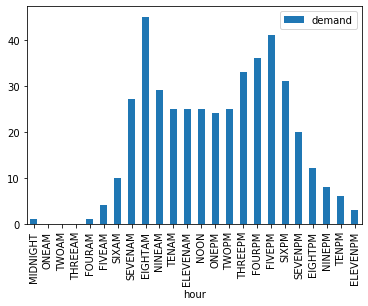

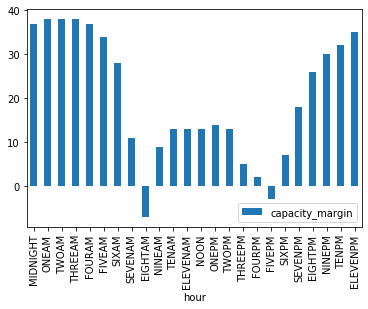

In [15]:
results = pd.DataFrame(results)

ax = results.plot.bar(x='hour', y='demand', rot=90)

print(ax)

ax = results.plot.bar(x='hour', y='capacity_margin', rot=90)

print(ax)

In [16]:
print(results)

    road_id      hour  vehicle_density  demand  capacity  capacity_margin
0     47528  MIDNIGHT               16       1        38               37
1     47528     ONEAM                6       0        38               38
2     47528     TWOAM                5       0        38               38
3     47528   THREEAM                5       0        38               38
4     47528    FOURAM               18       1        38               37
5     47528    FIVEAM               94       4        38               34
6     47528     SIXAM              255      10        38               28
7     47528   SEVENAM              687      27        38               11
8     47528   EIGHTAM             1130      45        38               -7
9     47528    NINEAM              733      29        38                9
10    47528     TENAM              634      25        38               13
11    47528  ELEVENAM              636      25        38               13
12    47528      NOON              616

In [25]:
road_filename = os.path.join('data','central_oxford.shp')

links = {}
for record in shpreader.Reader(road_filename).records():
    link = str(record.attributes['EdgeID'])
    geom = record.geometry
    links[link] = {
        'road_id': link,
        'geom': geom
    }
pprint.pprint(links)

{'47528': {'geom': <shapely.geometry.linestring.LineString object at 0x00000247E08242B0>,
           'road_id': '47528'},
 '55563': {'geom': <shapely.geometry.linestring.LineString object at 0x00000247E0A27BE0>,
           'road_id': '55563'},
 '59426': {'geom': <shapely.geometry.linestring.LineString object at 0x00000247E0A27EF0>,
           'road_id': '59426'},
 '69113': {'geom': <shapely.geometry.linestring.LineString object at 0x00000247DCC01240>,
           'road_id': '69113'},
 '70557': {'geom': <shapely.geometry.linestring.LineString object at 0x00000247E0824048>,
           'road_id': '70557'},
 '79226': {'geom': <shapely.geometry.linestring.LineString object at 0x00000247E0A27940>,
           'road_id': '79226'}}


In [44]:
links = gpd.read_file(os.path.join('data','central_oxford.shp'), crs= {"init": "epsg:4326"})

links = links.to_crs(epsg=3857)

print(links.head(2))

   EdgeID  Anode  Bnode     CP iDir   SRefE   SRefN  Distance    FFspeed  \
0   55563   2482   2483   7658    N  450000  209775       3.8  90.203731   
1   59426   7556   1805  27121    W  449950  206200       2.3  90.203731   

     FFtime IsFerry                                           geometry  
0  2.527612       F  LINESTRING (-140274.612 6756536.429, -142552.4...  
1  1.529870       F  LINESTRING (-141083.091 6755525.951, -144303.9...  


In [49]:
links = gpd.read_file(os.path.join('data','central_oxford.shp'), crs= {"init": "epsg:4326"})

links = links.to_crs(epsg=3857)

links = links.rename(columns={"EdgeID": "road_id"})

results = results[['road_id', 'hour', 'demand']]
links = links[['road_id', 'geometry']]

links = links.merge(results, on='road_id', how='left')

print(links.head(2))

   road_id                                           geometry hour  demand
0    55563  LINESTRING (-140274.612 6756536.429, -142552.4...  NaN     NaN
1    59426  LINESTRING (-141083.091 6755525.951, -144303.9...  NaN     NaN


In [50]:
flows = results.to_dict('records')

hourly_maxes = []
for interval_key, interval_name in [
        ('MIDNIGHT', '00'),
        ('ONEAM', '01'),
        ('TWOAM', '02'),
        ('THREEAM', '03'),
        ('FOURAM', '04'),
        ('FIVEAM', '05'),
        ('SIXAM', '06'),
        ('SEVENAM', '07'),
        ('EIGHTAM', '08'),
        ('NINEAM', '09'),
        ('TENAM', '10'),
        ('ELEVENAM', '11'),
        ('NOON', '12'),
        ('ONEPM', '13'),
        ('TWOPM', '14'),
        ('THREEPM', '15'),
        ('FOURPM', '16'),
        ('FIVEPM', '17'),
        ('SIXPM', '18'),
        ('SEVENPM', '19'),
        ('EIGHTPM', '20'),
        ('NINEPM', '21'),
        ('TENPM', '22'),
        ('ELEVENPM', '23')]:
    for item in flows:
        if item['hour'] == interval_key:
            hourly_maxes.append(item['demand'])

flow_max = max(hourly_maxes)

In [51]:
for interval_key, interval_name in [
#         ('MIDNIGHT', '00'),
#         ('ONEAM', '01'),
#         ('TWOAM', '02'),
#         ('THREEAM', '03'),
#         ('FOURAM', '04'),
#         ('FIVEAM', '05'),
#         ('SIXAM', '06'),
#         ('SEVENAM', '07'),
#         ('EIGHTAM', '08'),
        ('NINEAM', '09'),
        ('TENAM', '10'),
#         ('ELEVENAM', '11'),
#         ('NOON', '12'),
#         ('ONEPM', '13'),
#         ('TWOPM', '14'),
#         ('THREEPM', '15'),
#         ('FOURPM', '16'),
#         ('FIVEPM', '17'),
#         ('SIXPM', '18'),
#         ('SEVENPM', '19'),
#         ('EIGHTPM', '20'),
#         ('NINEPM', '21'),
#         ('TENPM', '22'),
#         ('ELEVENPM', '23')
    ]:


    plt.figure(figsize=(6, 10), dpi=150)
    
    ax = links.plot()

    ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN)
    ax.set_axis_off()

    plt.savefig(os.path.join('vis','test_{}'.format(interval_name)))
    plt.close()
    


<Figure size 900x1500 with 0 Axes>

<Figure size 900x1500 with 0 Axes>